# The ARI Model of Time Series
- An ARI model using lag number 7 and differenced once
- Trained and tested on a 63+18 dataset, step = 7
    - one model per trial instead of Walk Forward
- Evaluated with average RMSE, MAE, MAPE

In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("JointData.csv", index_col = False)
df = df[["date","cases"]]  # use only daily increment of cases to forcast
df.reset_index(drop=True, inplace=True)
df.head()

,date,cases
0,2020-07-27,207.0
1,2020-07-28,128.0
2,2020-07-29,126.0
3,2020-07-30,105.0
4,2020-07-31,112.0


# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [4]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# starting from the 7th day:
cases_ave = []
for i in range(6,len(df)):
    # remove day of week effect
    temp = np.mean(df.cases.iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
    cases_ave.append(temp)

df = df.iloc[6:].reset_index(drop = True)  # start on day 7, update index
df['case'] = cases_ave

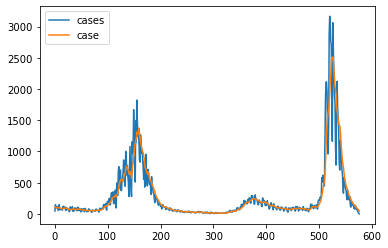

In [5]:
df.plot()
plt.show()  # cases- original data, case- smoothed version w/o day of week effect

In [6]:
df.head()

,date,cases,case
0,2020-08-02,46.0,114.142857
1,2020-08-03,147.0,105.571429
2,2020-08-04,91.0,100.285714
3,2020-08-05,114.0,98.571429
4,2020-08-06,116.0,100.142857


In [7]:
# work with time series:
df1 = df[["date", "case"]]
# df1["date"] = pd.to_datetime(df1["date"])  # convert to datatime
df1.set_index("date", inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 2020-08-02 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   case    577 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [8]:
df1 = df1.to_dict()['case']  # convert to dict in order to convert to series
s = pd.Series(df1)

# Data Reshaping

In [9]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    # rescale training data, no need to rescale testing data
    train, test = raw_values[-(test_size+train_size):-test_size], supervised_values[-test_size:]
    return train, test

## Evaluation with RMSE, MAE, MAPE

In [10]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(test, forecasts):
    rmse = np.sqrt(mean_squared_error(test, forecasts))
    mae = mean_absolute_error(test, forecasts)
    test = np.array(test)
    forecasts = np.array(forecasts)
    mape = mean_absolute_percentage_error(test, forecasts)*100
    return rmse, mae, mape

# Training Model

### AutoRegression
- assume observations from previous time steps are useful to predict values at latter time steps
    - true for Time Series
- choose a proper lag
    - use lag as variable
    - if all lag variables show no correlation with output, then the time series problem could be not predictable
    - Use the same lag number for AR, LSTM, and combined, for comparison

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$$
where $p$ is the lag number, p = 7

# A Single Trial as Demo

In [11]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size
# prepare data
train, test = prepare_data(s, test_size, n_lag, n_seq)

In [12]:
model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
model = model.fit()

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -329.399
Date:                Mon, 15 Aug 2022   AIC                            674.798
Time:                        01:23:19   BIC                            691.815
Sample:                             0   HQIC                           681.479
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7734      0.105      7.367      0.000       0.568       0.979
ar.L2          0.0617      0.138      0.448      0.654      -0.209       0.332
ar.L3          0.1093      0.200      0.545      0.586      -0.284       0.502
ar.L4         -0.1251      0.200     -0.624      0.533      -0.518       0.268
ar.L5         -0.0779      0.184     -0.423      0.673      -0.439       0.283
ar.L6          0.0833      0.188      0.443      0.658      -0.286       0.452
ar.L7          0.0454      0.128      0.355      0.722      -0.205       0.296
sigma2      2358.6499    353.892      6.665      0.000    1665.034    3052.266
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.01
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.42
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Evaluation

In [14]:
# make predictions
predictions = []
for i in range(test_size):
    # forecast for all test
    temp = 0  # initlialize with coefficient
    for j in range(n_lag):
        temp += model.params[j] * test[i][j]  # use real values
    predictions.append(temp)
# make real
actual = [row[n_lag:].tolist()[0] for row in test]
# compare and evaluate
rmse, mae, mape = evaluate_forecasts(actual, predictions)
print("Test RMSE: {}\n".format(rmse))
print("Test MAE: {}\n".format(mae))
print("Test MAPE: {}".format(mape))

Test RMSE: 74.0684397007439

Test MAE: 69.98885280055502

Test MAPE: 56.01826252741399


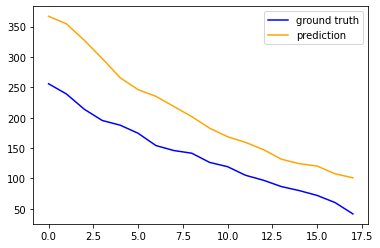

In [15]:
plt.plot(s.values[-test_size:], color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.legend()
plt.show()

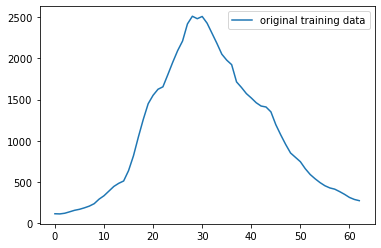

In [16]:
original_train = s[-(test_size+train_size):-test_size]
x = range(0,len(original_train))
plt.plot(x,original_train, label = "original training data")
plt.legend()
plt.show()

Notice: absence of a periodic trend. As a result, including more data does not always give us a better result
- how does the algorithm work on different training and testing sets, given the same size of each?

# Evaluate AR Method on Various Training & Testing Sets

In [17]:
n_step = 7  # step size
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
train_size = 63  # train set size
test_size = 18 # test set size

In [18]:
# for each date t
    # use [t, t + train_size) as training set
    # use [t + train_size, t + train_size + test_size) as testing set
    # evaluate by calculating RMSE

# holder for rmse:
RMSE = []
MAE = []
MAPE = []
for i in range(0, len(df)-(train_size+test_size)+1, n_step):  # len(df)-(train_size+test_size)+1
    # cut a data trial from original dataset
    X = df['case'][i:i+(train_size+test_size)]  # smoothed data
    train, test = prepare_data(X, test_size, n_lag, n_seq)
    # fit model
    model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
    model = model.fit()
    # make prediction
    predictions = []
    for i in range(test_size):
        # forecast for all test
        temp = 0  # initlialize with coefficient
        for j in range(n_lag):
            temp += model.params[j] * test[i][j]  # use real values
        predictions.append(temp)
    # make real
    actual = [row[n_lag:].tolist()[0] for row in test]
    # evaluate
    rmse, mae, mape = evaluate_forecasts(predictions, actual)
    RMSE.append(rmse)
    MAE.append(mae)
    MAPE.append(mape)

In [19]:
# create a data frame of 
    # date i
    # rmse of data trial starting on date i
date = [df['date'][i] for i in range(0, len(df)-(train_size+test_size)+1, n_step)]
AR_evaluate = {'date': date,
              'rmse': RMSE, 'mae': MAE, 'mape': MAPE}
AR_evaluate = pd.DataFrame(AR_evaluate)
AR_evaluate

,date,rmse,mae,mape
0,2020-08-02,65.896319,65.745558,540.833722
1,2020-08-09,76.821218,76.544862,354.476948
2,2020-08-16,99.121248,96.666029,336.312025
3,2020-08-23,150.457239,143.114204,309.032792
4,2020-08-30,195.225323,187.191120,464.262609
...,...,...,...,...
66,2021-11-07,492.372125,459.022882,23.435753
67,2021-11-14,380.894691,368.008229,25.543105
68,2021-11-21,307.037356,286.564494,30.443151
69,2021-11-28,258.385143,223.493162,34.696850


In [20]:
print("The average Root Mean Square Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['rmse'])))
print("The average Mean Absolute Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['mae'])))
print("The average Mean Absolute Percentage Error for AR(7) algorithm is {}".format(np.mean(AR_evaluate['mape'])))
print("\n")
print("The maximum of all RMSE is {}".format(max(RMSE)))
print("The maximum of all MAE is {}".format(max(MAE)))
print("The maximum of all MAPE is {}".format(max(MAPE)))

The average Root Mean Square Error for AR(7) algorithm is 142.4511040416624
The average Mean Absolute Error for AR(7) algorithm is 129.97488813787473
The average Mean Absolute Percentage Error for AR(7) algorithm is 516.1126597982018


The maximum of all RMSE is 1044.14080038621
The maximum of all MAE is 1014.8416773777361
The maximum of all MAPE is 17587.658706198657


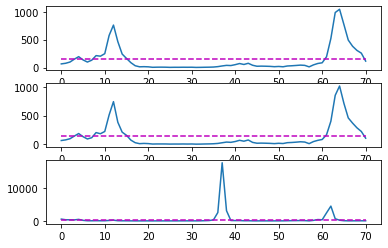

In [21]:
# plot RMSE, visualize with its 75% quantile
fig, (ax1,ax2,ax3) = plt.subplots(3, 1)

ax1.plot(RMSE)
up = np.quantile(RMSE, 0.75)
ax1.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

ax2.plot(MAE)
up = np.quantile(MAE, 0.75)
ax2.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

ax3.plot(MAPE)
up = np.quantile(MAPE, 0.75)
ax3.plot(range(len(AR_evaluate)),np.repeat(up,len(AR_evaluate)), 'm--')

plt.show()

From the graph, we observed that the abnormalty of RMSE and MAE generally corresponds.

# Identify and Visualize the Outliers

## The Maximum MAPE

In [22]:
# locate where the maximum MAPE take place
maximum = max(MAPE)
max_index = MAPE.index(maximum)*n_step
# print out the dates around maximum MAPE
df['date'][max_index]

'2021-04-18'

In [23]:
# fit the model on maximum RMSE
X = df['case'][max_index:max_index+(train_size+test_size)]  # smoothed data
train, test = prepare_data(X, test_size, n_lag, n_seq)

predictions = []
# model
model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
model = model.fit()
# make prediction
predictions = []
for i in range(test_size):
    # forecast for all test
    temp = 0  # initlialize with coefficient
    for j in range(n_lag):
        temp += model.params[j] * test[i][j]  # use real values
    predictions.append(temp)
# make real
actual = [row[n_lag:].tolist()[0] for row in test]
# evaluate
rmse, mae, mape = evaluate_forecasts(predictions, actual)
print("Test RMSE: {}\n".format(rmse))
print("Test MAE: {}\n".format(mae))
print("Test MAPE: {}".format(mape))

Test RMSE: 29.023495342097018

Test MAE: 26.751594596958817

Test MAPE: 17587.658706198657


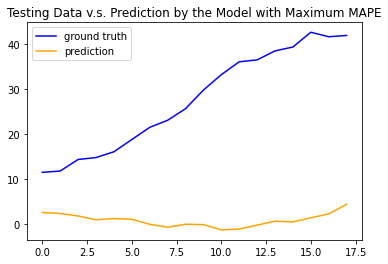

In [24]:
# visualize the model on maximum RMSE
plt.plot(actual, color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.title("Testing Data v.s. Prediction by the Model with Maximum MAPE")
plt.legend()
plt.show()

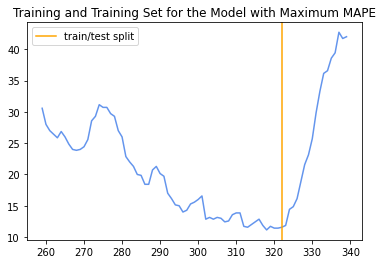

In [25]:
plt.plot(X, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = max_index+train_size, color = 'orange', label = 'train/test split')
plt.title("Training and Training Set for the Model with Maximum MAPE")
plt.legend()
plt.show()

## The Maximum RMSE

In [26]:
# locate where the maximum RMSE take place
maximum = max(RMSE)
max_index = RMSE.index(maximum)*n_step
# print out the dates around maximum RMSE
df['date'][max_index]

'2021-10-24'

In [27]:
# fit the model on maximum RMSE
X = df['case'][max_index:max_index+(train_size+test_size)]  # smoothed data
train, test = prepare_data(X, test_size, n_lag, n_seq)

predictions = []
# model
model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
model = model.fit()
# make prediction
predictions = []
for i in range(test_size):
    # forecast for all test
    temp = 0  # initlialize with coefficient
    for j in range(n_lag):
        temp += model.params[j] * test[i][j]  # use real values
    predictions.append(temp)
# make real
actual = [row[n_lag:].tolist()[0] for row in test]
# evaluate
rmse, mae, mape = evaluate_forecasts(predictions, actual)
print("Test RMSE: {}\n".format(rmse))
print("Test MAE: {}\n".format(mae))
print("Test MAPE: {}".format(mape))

Test RMSE: 1044.14080038621

Test MAE: 1014.8416773777361

Test MAPE: 208.18347342824984


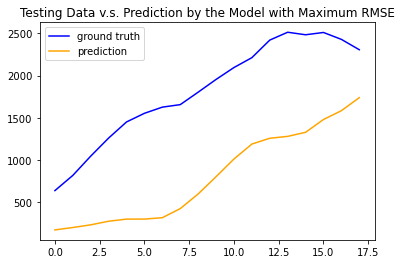

In [28]:
# visualize the model on maximum RMSE
plt.plot(actual, color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.title("Testing Data v.s. Prediction by the Model with Maximum RMSE")
plt.legend()
plt.show()

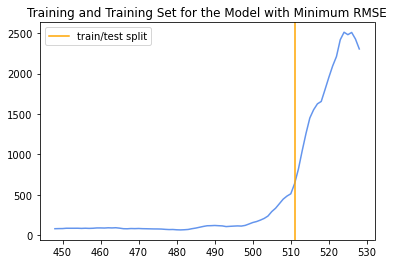

In [29]:
plt.plot(X, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = max_index+train_size, color = 'orange', label = 'train/test split')
plt.title("Training and Training Set for the Model with Minimum RMSE")
plt.legend()
plt.show()

## The Minimum RMSE

- check where the model works the best

In [30]:
# locate where the minimum RMSE take place
minimum = min(RMSE)
min_index = RMSE.index(minimum)*n_step
# print out the dates around minimum RMSE
df['date'][min_index]

'2021-03-07'

In [31]:
# fit the model on minimum RMSE
X = df['case'][min_index:min_index+(train_size+test_size)]  # smoothed data
train, test = prepare_data(X, test_size, n_lag, n_seq)

predictions = []
# model
model = ARIMA(train, order = (n_lag,1,0))  # AR, I, MA
model = model.fit()
# make prediction
predictions = []
for i in range(test_size):
    # forecast for all test
    temp = 0  # initlialize with coefficient
    for j in range(n_lag):
        temp += model.params[j] * test[i][j]  # use real values
    predictions.append(temp)
# make real
actual = [row[n_lag:].tolist()[0] for row in test]
# evaluate
rmse, mae, mape = evaluate_forecasts(predictions, actual)
print("Test RMSE: {}\n".format(rmse))
print("Test MAE: {}\n".format(mae))
print("Test MAPE: {}".format(mape))

Test RMSE: 2.900867521367455

Test MAE: 2.367251218580384

Test MAPE: 14.112470108803713


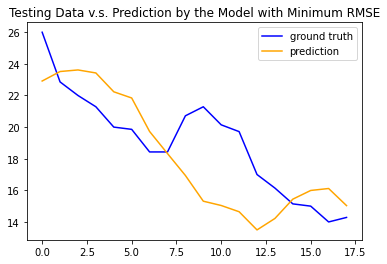

In [32]:
# visualize the model on maximum RMSE
plt.plot(actual, color = 'blue', label = "ground truth")
plt.plot(predictions, color = 'orange', label = "prediction")
plt.title("Testing Data v.s. Prediction by the Model with Minimum RMSE")
plt.legend()
plt.show()

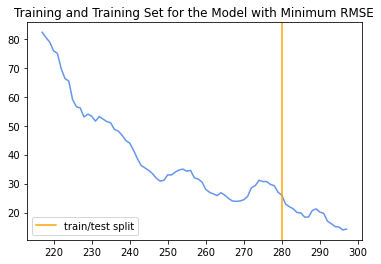

In [33]:
plt.plot(X, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = min_index+train_size, color = 'orange', label = 'train/test split')
plt.title("Training and Training Set for the Model with Minimum RMSE")
plt.legend()
plt.show()